In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import wikipedia

import gensim
import spacy
from spacy import displacy
import textacy

In [34]:
class WikiPageRetriever:
    @staticmethod
    def retrieve_page(page: str, lang:str = 'en') -> str:
        import wikipedia
        wikipedia.set_lang(lang)
        return wikipedia.page(page)

In [35]:
topic = "Iran–Iraq War"
wiki_article = WikiPageRetriever.retrieve_page(topic)


In [60]:
txt = wiki_article.content[:wiki_article.content.find("Terminology")]

In [61]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(txt)

In [62]:
lst_docs = [sent for sent in doc.sents]
print(len(lst_docs))

20


In [63]:
i = 0
print(lst_docs[i])
for token in lst_docs[i]:
    print(token.text, "-->", "pos: "+token.pos_, "|", "dep: "+token.dep_, "")


The Iran–Iraq War was an armed conflict between Iran and Iraq that lasted from September 1980 to August 1988.
The --> pos: DET | dep: det 
Iran --> pos: PROPN | dep: nmod 
– --> pos: PUNCT | dep: punct 
Iraq --> pos: PROPN | dep: compound 
War --> pos: PROPN | dep: nsubj 
was --> pos: AUX | dep: ROOT 
an --> pos: DET | dep: det 
armed --> pos: ADJ | dep: amod 
conflict --> pos: NOUN | dep: attr 
between --> pos: ADP | dep: prep 
Iran --> pos: PROPN | dep: pobj 
and --> pos: CCONJ | dep: cc 
Iraq --> pos: PROPN | dep: conj 
that --> pos: PRON | dep: nsubj 
lasted --> pos: VERB | dep: relcl 
from --> pos: ADP | dep: prep 
September --> pos: PROPN | dep: pobj 
1980 --> pos: NUM | dep: nummod 
to --> pos: ADP | dep: prep 
August --> pos: PROPN | dep: pobj 
1988 --> pos: NUM | dep: nummod 
. --> pos: PUNCT | dep: punct 


In [64]:
displacy.render(lst_docs[i], style="dep", options={"distance":100})


In [67]:
for tag in lst_docs[0].ents:
    print(tag.text, f"({tag.label_})") 

Iran (GPE)
Iran (GPE)
Iraq (GPE)
September 1980 to August 1988 (DATE)


In [68]:
displacy.render(lst_docs[i], style="ent")


In [69]:
lst_docs

[The Iran–Iraq War was an armed conflict between Iran and Iraq that lasted from September 1980 to August 1988.,
 It began with the Iraqi invasion of Iran and lasted for almost eight years, until the acceptance of United Nations Security Council Resolution 598 by both sides.,
 Iraq's primary rationale for the attack against Iran cited the need to prevent Ruhollah Khomeini—who had spearheaded Iran's Islamic Revolution in 1979—from exporting the new Iranian ideology to Iraq; there were also fears among the Iraqi leadership of Saddam Hussein that Iran, a theocratic state with a population predominantly composed of Shia Muslims, would exploit sectarian tensions in Iraq by rallying Iraq's Shia majority against the Baʽathist government, which was officially secular and dominated by Sunni Muslims.,
 Iraq also wished to replace Iran as the power player in the Persian Gulf, which was not seen as an achievable objective prior to the Islamic Revolution because of Pahlavi Iran's economic and milita

In [70]:
## extract entities and relations
dic = {"id":[], "text":[], "entity":[], "relation":[], "object":[]}

for n,sentence in enumerate(lst_docs):
    lst_generators = list(textacy.extract.subject_verb_object_triples(sentence))  
    for sent in lst_generators:
        subj = "_".join(map(str, sent.subject))
        obj  = "_".join(map(str, sent.object))
        relation = "_".join(map(str, sent.verb))
        # print(subj)
        dic["id"].append(n)
        dic["text"].append(sentence.text)
        dic["entity"].append(subj)
        dic["object"].append(obj)
        dic["relation"].append(relation)



In [71]:
dtf = pd.DataFrame(dic)

In [72]:
## extract attributes
attribute = "DATE"
dic = {"id":[], "text":[], attribute:[]}

for n,sentence in enumerate(lst_docs):
    lst = list(textacy.extract.entities(sentence, include_types={attribute}))
    if len(lst) > 0:
        for attr in lst:
            dic["id"].append(n)
            dic["text"].append(sentence.text)
            dic[attribute].append(str(attr))
    else:
        dic["id"].append(n)
        dic["text"].append(sentence.text)
        dic[attribute].append(np.nan)

dtf_att = pd.DataFrame(dic)
dtf_att = dtf_att[~dtf_att[attribute].isna()]

In [73]:
dtf_att[dtf_att["id"]==i]


,id,text,DATE
0,0,The Iran–Iraq War was an armed conflict betwee...,September 1980 to August 1988


In [74]:
import networkx as nx 

/Users/f.shammary/Documents/Github/01_my_github/knowledge_graphs/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


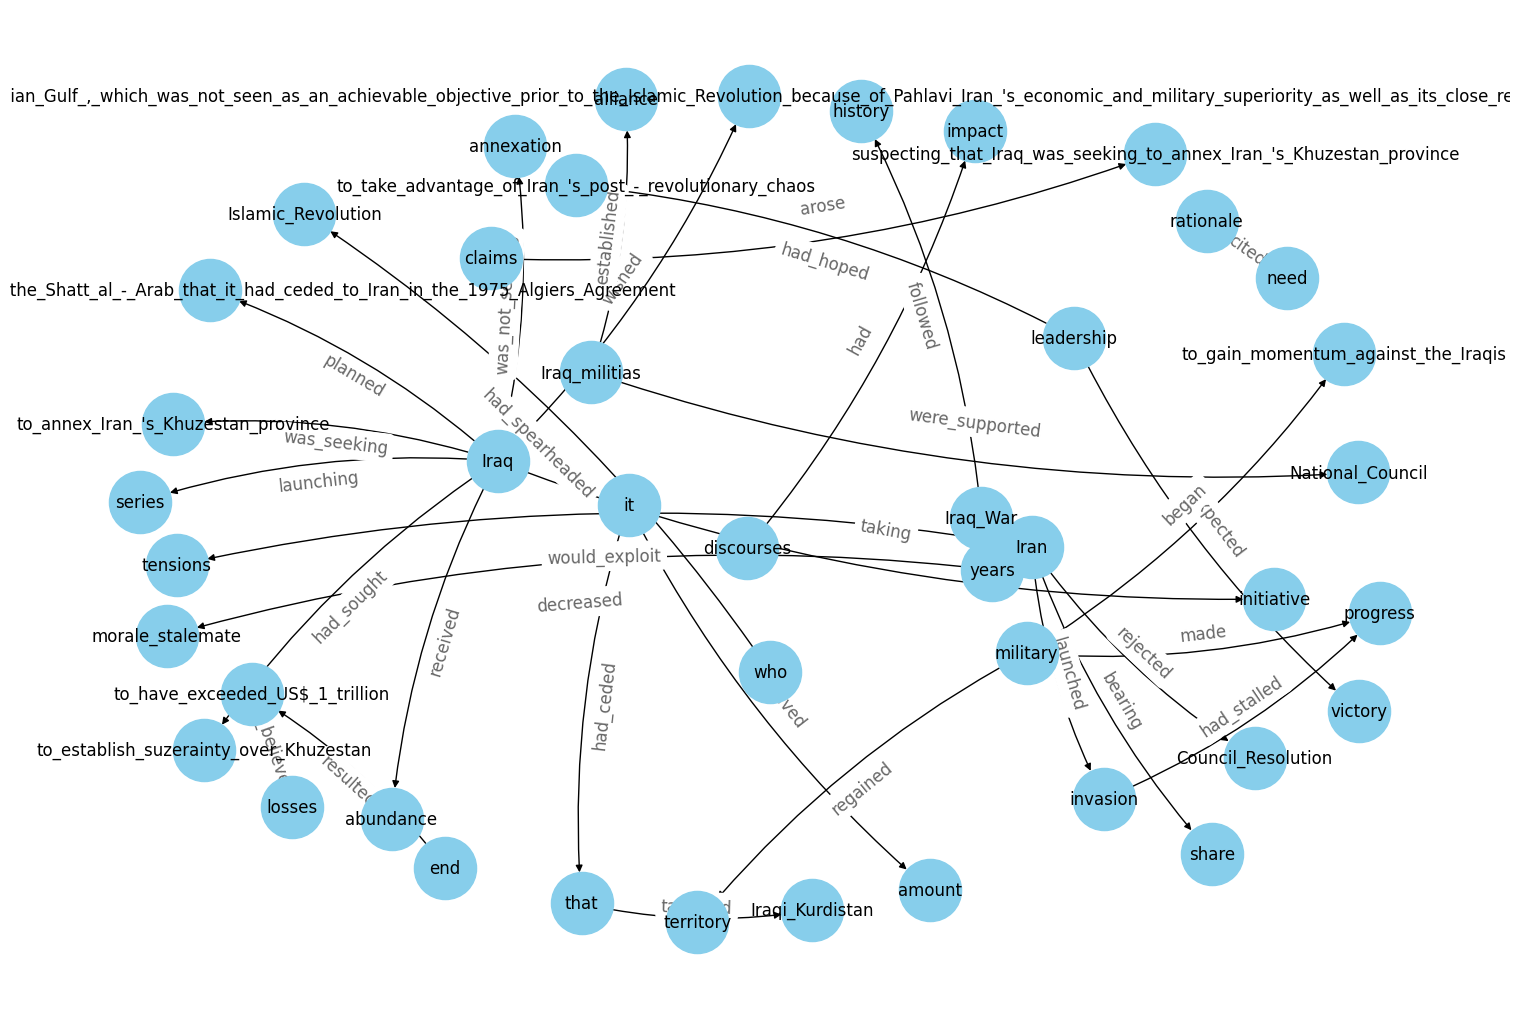

In [75]:
## create full graph
G = nx.from_pandas_edgelist(dtf, source="entity", target="object", 
                            edge_attr="relation", 
                            create_using=nx.DiGraph())


## plot
plt.figure(figsize=(15,10))

pos = nx.spring_layout(G, k=1)
node_color = "skyblue"
edge_color = "black"

nx.draw(G, pos=pos, with_labels=True, node_color=node_color, 
        edge_color=edge_color, cmap=plt.cm.Dark2, 
        node_size=2000, connectionstyle='arc3,rad=0.1')

nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5, 
                         edge_labels=nx.get_edge_attributes(G,'relation'),
                         font_size=12, font_color='black', alpha=0.6)
plt.show()

In [76]:
dtf["entity"].value_counts().head()


entity
Iraq          8
Iran          4
military      3
it            2
leadership    2
Name: count, dtype: int64

In [77]:
## filter
f = "Iraq"
tmp = dtf[(dtf["entity"]==f) | (dtf["object"]==f)]


## create small graph
G = nx.from_pandas_edgelist(tmp, source="entity", target="object", 
                            edge_attr="relation", 
                            create_using=nx.DiGraph())


## plot
plt.figure(figsize=(15,10))

pos = nx.nx_agraph.graphviz_layout(G, prog="neato")
node_color = ["red" if node==f else "skyblue" for node in G.nodes]
edge_color = ["red" if edge[0]==f else "black" for edge in G.edges]

nx.draw(G, pos=pos, with_labels=True, node_color=node_color, 
        edge_color=edge_color, cmap=plt.cm.Dark2, 
        node_size=2000, node_shape="o", connectionstyle='arc3,rad=0.1')

nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5, 
                        edge_labels=nx.get_edge_attributes(G,'relation'),
                        font_size=12, font_color='black', alpha=0.6)
plt.show()

ImportError: requires pygraphviz http://pygraphviz.github.io/

<Figure size 1500x1000 with 0 Axes>